# Ensemble models

gwlearn implements geographically weighted versions of ensemble models for both classification and regression tasks. For classification, there's a caveat: given it is unlikely that all categories are present in all local models, fitting a non-binary would lead to inconsistent local models. Hence gwlearn currently supports only binary classification.

In [1]:
import geopandas as gpd
from geodatasets import get_path
from sklearn import metrics

from gwlearn.ensemble import (
    GWGradientBoostingClassifier,
    GWGradientBoostingRegressor,
    GWRandomForestClassifier,
    GWRandomForestRegressor,
)

Get sample data

In [2]:
gdf = gpd.read_file(get_path("geoda.south")).to_crs(5070)

gdf["point"] = gdf.representative_point()
gdf = gdf.set_geometry("point")

y = gdf["FH90"] > gdf["FH90"].median()
X = gdf.iloc[:, 9:15]

## Random Forest (Classification)

The implementation of geographically-weighted random forest classifier follows the logic of linear models, where each local neighborhood defined by a set bandwidth is used to fit a single local model.

In [3]:
gwrf = GWRandomForestClassifier(
    bandwidth=150,
    fixed=False,
)
gwrf.fit(
    X,
    y,
    geometry=gdf.geometry,
)

,bandwidth,150
,fixed,False
,kernel,'bisquare'
,include_focal,False
,graph,None
,n_jobs,-1
,fit_global_model,True
,strict,False
,keep_models,False
,temp_folder,None
,batch_size,None


### Focal score

The performance of these models can be measured in three ways. The first one is using the focal prediction. Unlike in linear models, where the focal observation is part of the local model training, in this case it is excluded to ensure it can be used to evaluate the model. Otherwise, it would be a part of the data the local model has seen and would report unrealistically high performance. If you want to include the focal observation in the training nevertheless, just set `include_focal=True`.

Focal accuracy can be measured as follows. Note that some local models are not fitted due to [imbalance rules](imbalance.ipynb), and report NA that needs to be filtered out.

In [4]:
na_mask = gwrf.pred_.notna()

metrics.accuracy_score(y[na_mask], gwrf.pred_[na_mask])

0.7629127857747672

### Pooled out-of-bag score

Another option is to pull the out-of-bag predictions from individual local models and pool them together. This uses more data to evaluate the model but given the local models are tuned for their focal location, some predictions on locations far from the focal point may be artifically worse than the actual model prediction would be.

In [5]:
metrics.accuracy_score(gwrf.oob_y_pooled_, gwrf.oob_pred_pooled_)

0.7441659610499577

### Local score

The final option is to take the local out-of-bag predicitons and measure performance per each local model. To do that, you can use a method `local_metric()`.

In [6]:
local_accuracy = gwrf.local_metric(metrics.accuracy_score)
local_accuracy

array([0.66      , 0.68      , 0.68666667, ..., 0.60666667, 0.73333333,
       0.65333333], shape=(1412,))

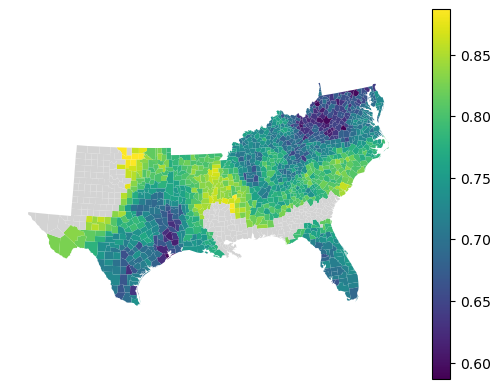

In [7]:
gdf.set_geometry("geometry").plot(
    local_accuracy, legend=True, missing_kwds=dict(color="lightgray")
).set_axis_off()

### Feature importance

Feature importances are reported for each local model.

In [8]:
gwrf.feature_importances_

,HR60,HR70,HR80,HR90,HC60,HC70
0,0.167425,0.160980,0.219654,0.223062,0.105426,0.123454
1,0.189743,0.161172,0.192244,0.210871,0.118758,0.127213
2,0.180702,0.153087,0.206769,0.236581,0.112439,0.110423
3,0.180881,0.148395,0.190255,0.237731,0.117996,0.124741
4,0.136414,0.180865,0.230172,0.201541,0.113974,0.137034
...,...,...,...,...,...,...
1407,0.130296,0.176474,0.274353,0.228239,0.091931,0.098708
1408,0.159641,0.172081,0.215510,0.233609,0.117273,0.101886
1409,0.171695,0.174373,0.194986,0.213842,0.133245,0.111858
1410,0.156362,0.184113,0.212814,0.200459,0.105481,0.140770


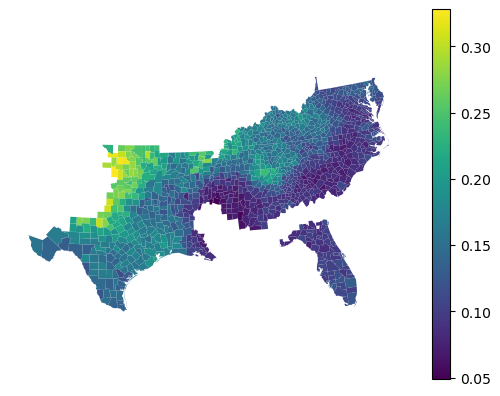

In [9]:
gdf.set_geometry("geometry").plot(
    gwrf.feature_importances_["HC60"], legend=True
).set_axis_off()

You can compare all of this to values extracted from a global model, fitted alongside.

In [10]:
gwrf.global_model.feature_importances_

array([0.14318089, 0.16261786, 0.21768723, 0.25580473, 0.1118941 ,
       0.10881518])

In [11]:
gwrf.feature_importances_.mean()

HR60    0.154460
HR70    0.159310
HR80    0.202752
HR90    0.221745
HC60    0.139419
HC70    0.122314
dtype: float64

## Gradient boosting

If you prefer to use gradient boosting, there is a minimal implementation of geographically weighted gradient boosting classifier, following the same model described for the random forest above.

In [12]:
gwgb = GWGradientBoostingClassifier(
    bandwidth=150,
    fixed=False,
)
gwgb.fit(
    X,
    y,
    geometry=gdf.geometry,
)

,bandwidth,150
,fixed,False
,kernel,'bisquare'
,include_focal,False
,graph,None
,n_jobs,-1
,fit_global_model,True
,strict,False
,keep_models,False
,temp_folder,None
,batch_size,None


Given the nature of the model, the outputs are a bit more limited. You can still extract focal predictions.

In [13]:
nan_mask = gwgb.pred_.notna()

metrics.accuracy_score(y[nan_mask], gwgb.pred_[nan_mask])

0.7510584250635055

And local feature importances.

In [14]:
gwgb.feature_importances_

,HR60,HR70,HR80,HR90,HC60,HC70
0,0.146542,0.246341,0.186469,0.220075,0.091630,0.108942
1,0.195373,0.187644,0.208081,0.236588,0.075434,0.096882
2,0.245876,0.132553,0.167656,0.287511,0.060045,0.106359
3,0.151374,0.195459,0.169973,0.266186,0.109701,0.107307
4,0.071598,0.181803,0.254541,0.240717,0.098784,0.152556
...,...,...,...,...,...,...
1407,0.120939,0.172742,0.384135,0.253409,0.027729,0.041046
1408,0.231353,0.148853,0.276677,0.207220,0.088689,0.047208
1409,0.151950,0.305919,0.247889,0.177921,0.074972,0.041349
1410,0.120377,0.231963,0.263519,0.230966,0.032646,0.120528


### Leave out samples

However, the pooled data are not available. In this case, you can use the `leave_out` keyword to leave out a fraction (when float) or a set number (when int) of random observations from each local model. For these, the local model does prediction and returns as `left_out_proba_` and `left_out_y_` arrays.

In [15]:
gwgb_leave = GWGradientBoostingClassifier(
    bandwidth=150,
    fixed=False,
    leave_out=0.2,
)
gwgb_leave.fit(
    X,
    y,
    geometry=gdf.geometry,
)

,bandwidth,150
,fixed,False
,kernel,'bisquare'
,include_focal,False
,graph,None
,n_jobs,-1
,fit_global_model,True
,strict,False
,keep_models,False
,temp_folder,None
,batch_size,None


In [16]:
metrics.accuracy_score(
    gwgb_leave.left_out_y_, gwgb_leave.left_out_proba_.argmax(axis=1)
)

0.7238216200959638

## Random Forest (Regression)

The `GWRandomForestRegressor` provides the same functionality as the classifier version but for continuous target variables. It uses local Random Forest models to capture spatial heterogeneity in regression relationships.

In [17]:
y_reg = gdf["FH90"]

In [18]:
gwrf_reg = GWRandomForestRegressor(
    bandwidth=150,
    fixed=False,
    random_state=0,
)
gwrf_reg.fit(
    X,
    y_reg,
    geometry=gdf.representative_point(),
)

,bandwidth,150
,fixed,False
,kernel,'bisquare'
,include_focal,False
,graph,None
,n_jobs,-1
,fit_global_model,True
,strict,False
,keep_models,False
,temp_folder,None
,batch_size,None


The regressor provides local R² values showing how well the model fits in each neighborhood:

In [19]:
gwrf_reg.local_r2_.head()

0    0.106911
1    0.035941
2   -0.034754
3   -0.047567
4    0.638350
dtype: float64

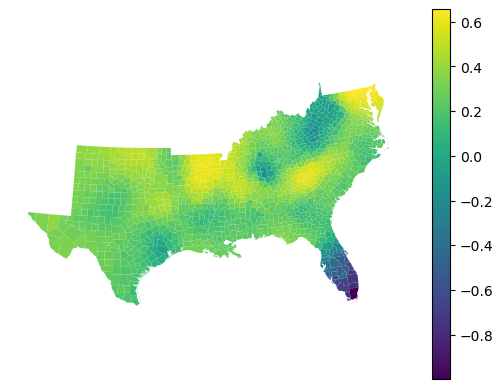

In [20]:
gdf.set_geometry("geometry").plot(gwrf_reg.local_r2_, legend=True).set_axis_off()

### Out-of-bag performance

Like the classifier, the regressor supports out-of-bag predictions that can be used to evaluate model performance:

In [21]:
from sklearn.metrics import r2_score

r2_score(gwrf_reg.oob_y_pooled_, gwrf_reg.oob_pred_pooled_)

0.5010449029248458

### Feature importance

Feature importances show the contribution of each feature in local models:

In [22]:
gwrf_reg.feature_importances_.head()

,HR60,HR70,HR80,HR90,HC60,HC70
0,0.114100,0.168689,0.170559,0.289199,0.067037,0.190415
1,0.124203,0.150558,0.175680,0.285489,0.058421,0.205648
2,0.151688,0.152122,0.179130,0.333070,0.056245,0.127745
3,0.137634,0.158571,0.171968,0.307446,0.050256,0.174126
4,0.051014,0.092811,0.264638,0.335068,0.125840,0.130629


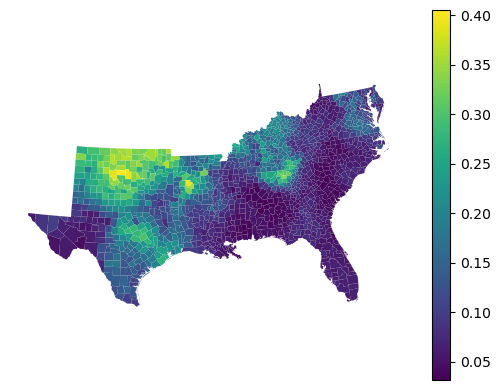

In [23]:
gdf.set_geometry("geometry").plot(
    gwrf_reg.feature_importances_["HC60"], legend=True
).set_axis_off()

## Gradient Boosting (Regression)

In the `GWGradientBoostingRegressor`, gradient boosting is applied for regression, taking into consideration the spatial heterogeneity. Gradient boosting is a type of boosting that builds a model by adding trees on a sequentially iterative basis; every new tree attempts to predict the errors made by the preceding ensemble. This makes the gradient boosting regressor appropriately suited for modeling complex non-linear relationships.

Unlike Random Forest, out-of-bag predictions are not implemented for Gradient Boosting in gwlearn. If you want to evaluate your model without a separate test dataset, you can use the `leave_out` option (as shown in the classifier section) or consider using `GWRandomForestRegressor`, which provides built-in OOB scoring.

In [24]:
gwgb_reg = GWGradientBoostingRegressor(
    bandwidth=150,
    fixed=False,
    random_state=0,
)
gwgb_reg.fit(
    X,
    y_reg,
    geometry=gdf.representative_point(),
)

,bandwidth,150
,fixed,False
,kernel,'bisquare'
,include_focal,False
,graph,None
,n_jobs,-1
,fit_global_model,True
,strict,False
,keep_models,False
,temp_folder,None
,batch_size,None


The regressor provides local R² values showing how well the model fits in each neighborhood:

In [25]:
gwgb_reg.local_r2_.head()

0   -0.065368
1   -0.163699
2   -0.280521
3   -0.266978
4    0.601586
dtype: float64

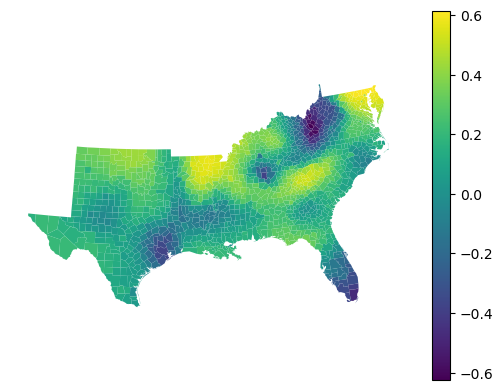

In [26]:
gdf.set_geometry('geometry').plot(gwgb_reg.local_r2_, legend=True).set_axis_off()

### Feature importance

Gradient boosting computes feature importances based on how much each feature reduces the loss function across all trees in the ensemble. These importances tend to be more focused on the most predictive features compared to Random Forest:

In [27]:
gwgb_reg.feature_importances_.head()

,HR60,HR70,HR80,HR90,HC60,HC70
0,0.094772,0.126039,0.205873,0.279788,0.054157,0.239371
1,0.096673,0.147720,0.154409,0.299136,0.060590,0.241473
2,0.083069,0.144368,0.210507,0.412651,0.034065,0.115338
3,0.096297,0.149892,0.176716,0.373721,0.029087,0.174287
4,0.028396,0.050586,0.132711,0.672995,0.030945,0.084366


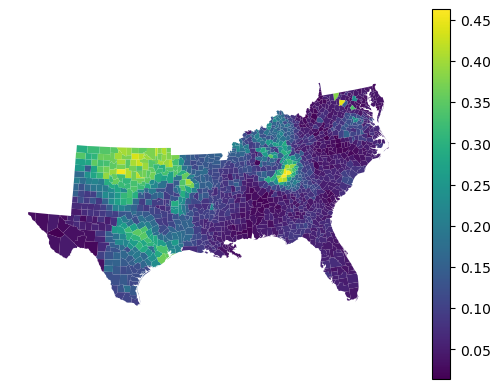

In [28]:
gdf.set_geometry('geometry').plot(gwgb_reg.feature_importances_["HC60"], legend=True).set_axis_off()

### Comparison with global model

You can compare the local feature importances to values from the global model:

In [29]:
gwgb_reg.global_model.feature_importances_

array([0.065497  , 0.10289156, 0.20545583, 0.45838082, 0.10810862,
       0.05966617])

In [30]:
gwgb_reg.feature_importances_.mean()

HR60    0.127078
HR70    0.121741
HR80    0.223678
HR90    0.301617
HC60    0.123668
HC70    0.102218
dtype: float64